In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import healpy as hp
from scipy.stats import binned_statistic
import rubin_sim.maf as maf
from rubin_sim.data import get_baseline
from rubin_sim.maf import TemplateTime

In [2]:
nside = 64
s = maf.HealpixSlicer(nside=nside)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [3]:
opsdb = get_baseline()
run_name = os.path.split(opsdb)[-1].replace('.db', '')

# %pdb

In [4]:
bdict = {}
for f in 'ugrizy':
    m = TemplateTime(metric_name=f'Template {f}')
    constraint = f'filter == "{f}" and night < 365'
    bdict[f] = maf.MetricBundle(m, s, constraint, run_name=run_name)
    
g = maf.MetricBundleGroup(bdict, opsdb, 'default')
g.run_all()

In [4]:
bdict = {}
for f in 'ugrizy':
    m = TemplateTime(metric_name=f'Template {f}', n_images_in_template = 5, seeing_percentile = 25, m5_percentile = 25)
    constraint = f'filter == "{f}" and night < 365'
    bdict[f] = maf.MetricBundle(m, s, constraint, run_name=run_name)

metric_configuration = 'five_images_in_template'
g = maf.MetricBundleGroup(bdict, opsdb, metric_configuration)
g.run_all()

In [5]:
bdict.keys()

dict_keys(['u', 'g', 'r', 'i', 'z', 'y', 'Template r_reduceN_images_until_template', 'Template r_reduceN_images_with_template', 'Template r_reduceN_nights_without_template', 'Template r_reduceNight_template_created', 'Template r_reduceTemplate_m5', 'Template r_reduceTotal_alerts', 'Template y_reduceN_images_until_template', 'Template y_reduceN_images_with_template', 'Template y_reduceN_nights_without_template', 'Template y_reduceNight_template_created', 'Template y_reduceTemplate_m5', 'Template y_reduceTotal_alerts', 'Template z_reduceN_images_until_template', 'Template z_reduceN_images_with_template', 'Template z_reduceN_nights_without_template', 'Template z_reduceNight_template_created', 'Template z_reduceTemplate_m5', 'Template z_reduceTotal_alerts', 'Template i_reduceN_images_until_template', 'Template i_reduceN_images_with_template', 'Template i_reduceN_nights_without_template', 'Template i_reduceNight_template_created', 'Template i_reduceTemplate_m5', 'Template i_reduceTotal_aler

In [5]:
def get_lc(v):
    """Extract lightcurves saved with `outputLc=True` from the metric datastructure
    
    Parameters
    ----------
    v : `metricValue`
        Input metricValue containing the lightcurve
    
    Returns
    -------
    lc : dict
        dict with columns `t`, `mag`, `mag_unc`, `maglim`, `filter`
    """
    if v is not None:
        return v['Diffim_lc']
    else:
        pass
        #return None

In [6]:
lcs_all_filters = {}
for f in 'ugrizy':
    lcs = [get_lc(v) for v in bdict[f].metric_values.tolist() if get_lc(v) is not None]
    lcs = [lc for lc in lcs if len(lc['diff_m5']) > 0] # time series of limiting magnitude
    lcs_all_filters[f] = lcs

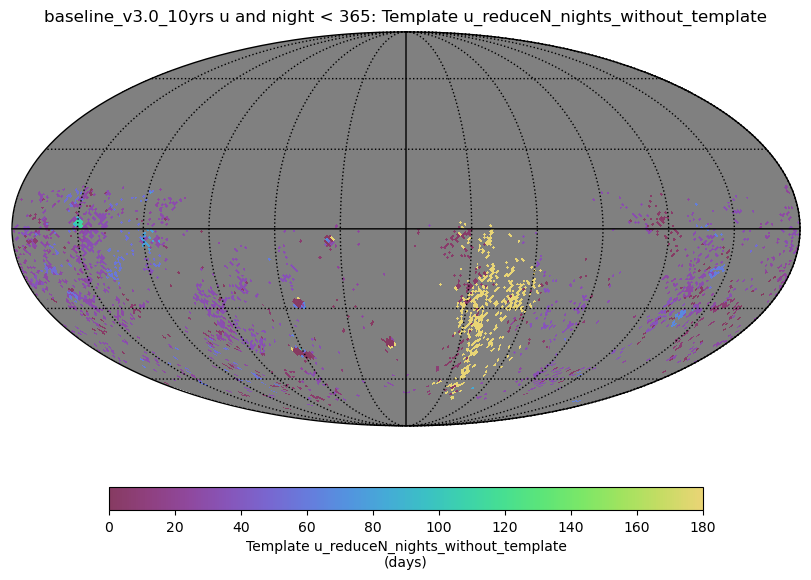

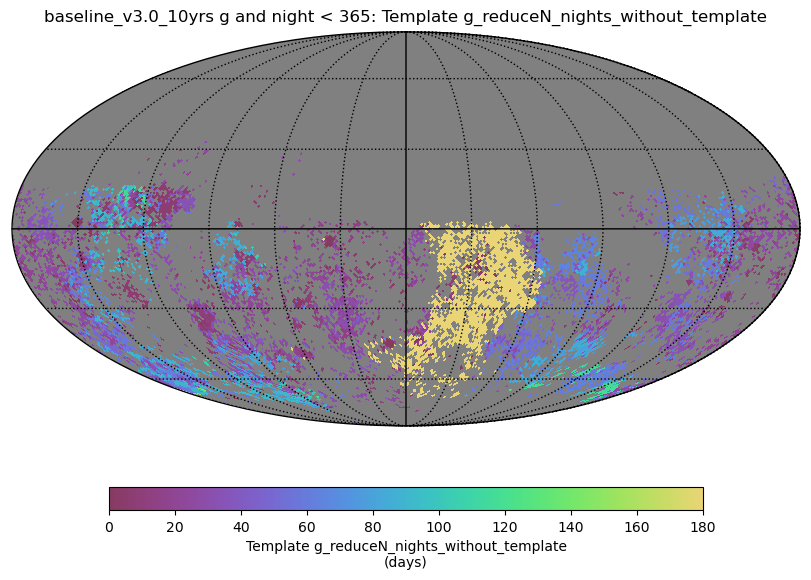

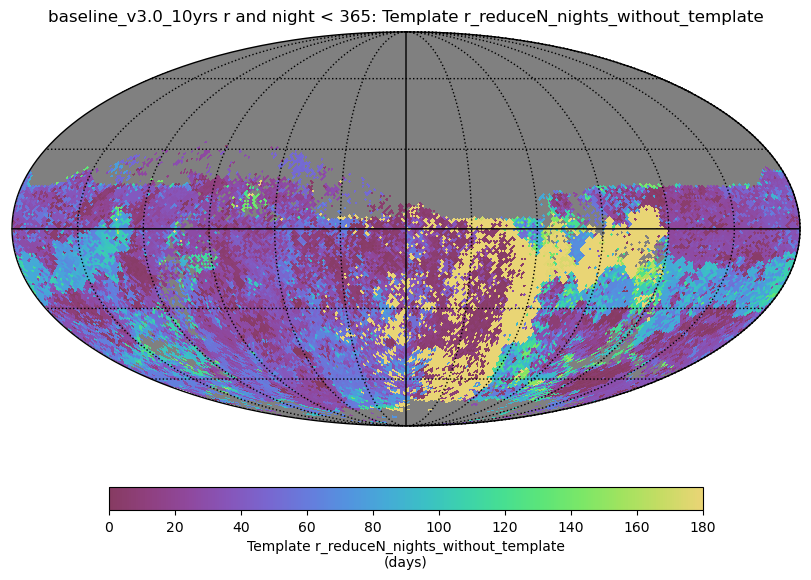

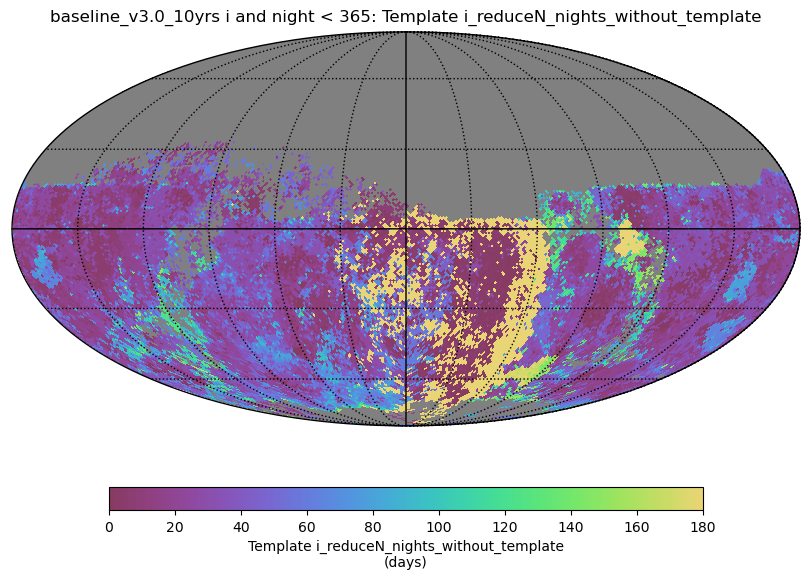

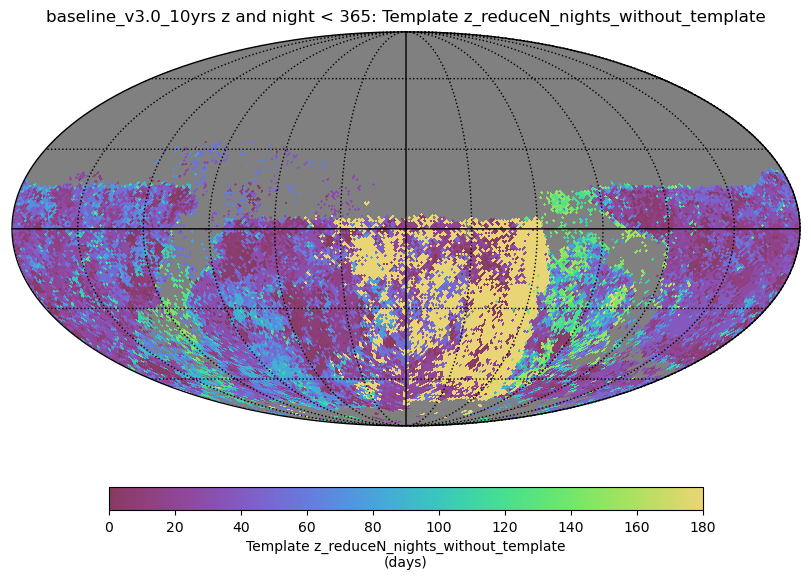

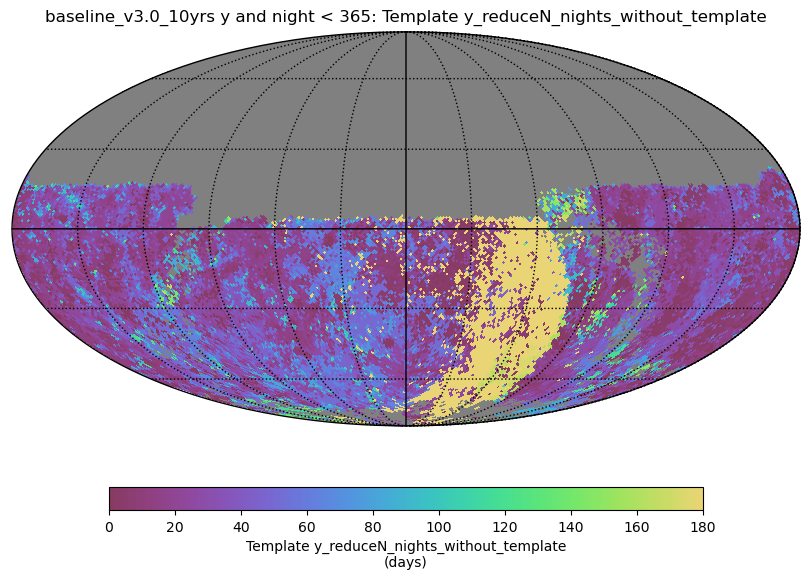

In [8]:
ph = maf.PlotHandler(out_dir='temp', thumbnail=False)

for f in 'ugrizy':
    k = f'Template {f}_reduceN_nights_without_template'
    ph.set_metric_bundles([bdict[k]])
    plotDict = {'figsize': (8, 6), 'color_min': 0, 'color_max': 180}
    ph.plot(plot_func=maf.HealpixSkyMap(), plot_dicts=plotDict)
    plt.savefig(f'{metric_configuration}_{f}_N_nights_without_template_max_180.pdf')

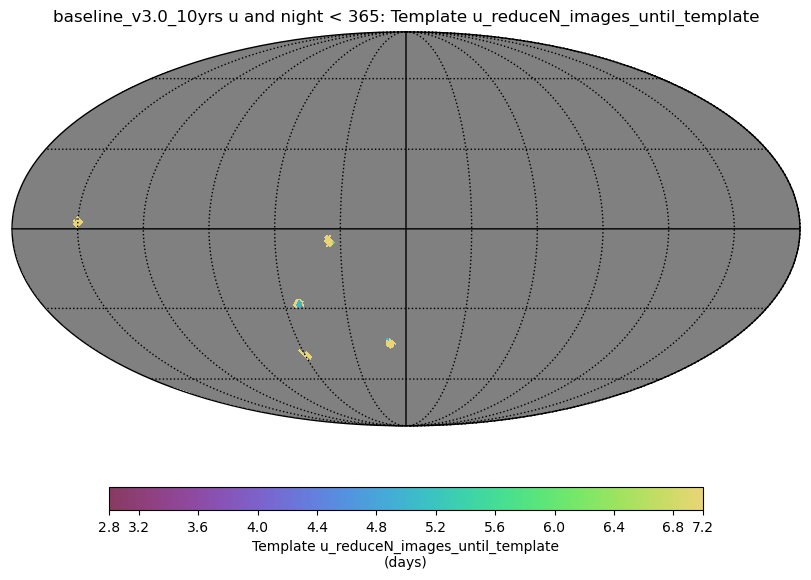

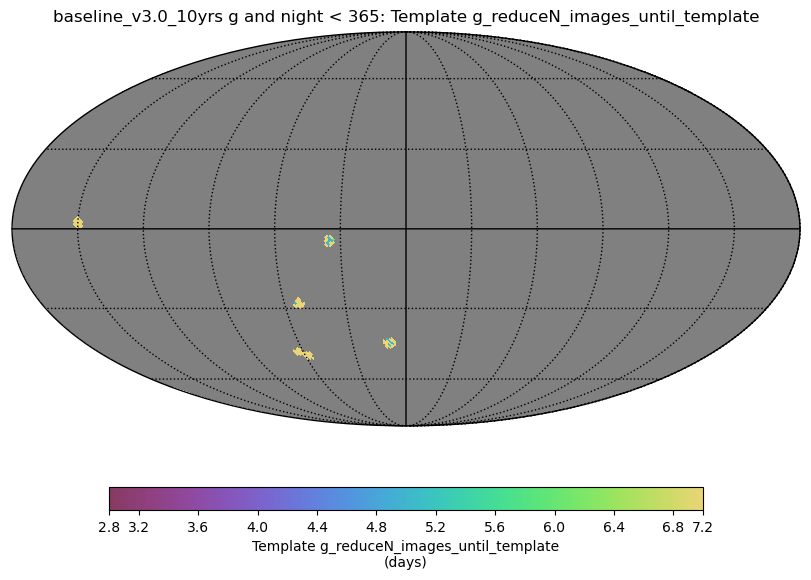

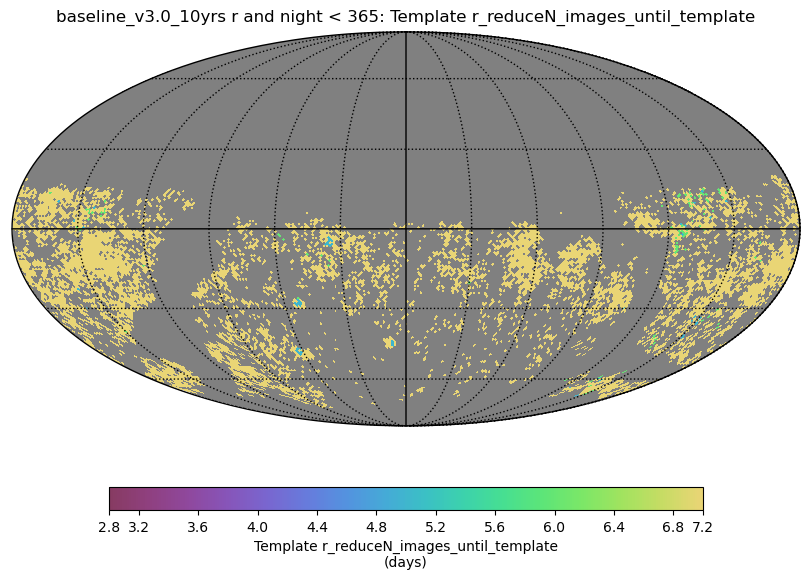

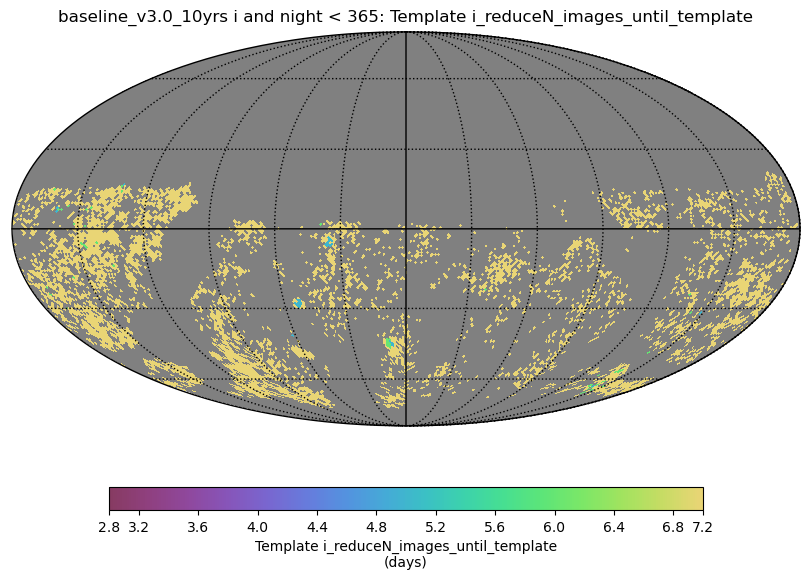

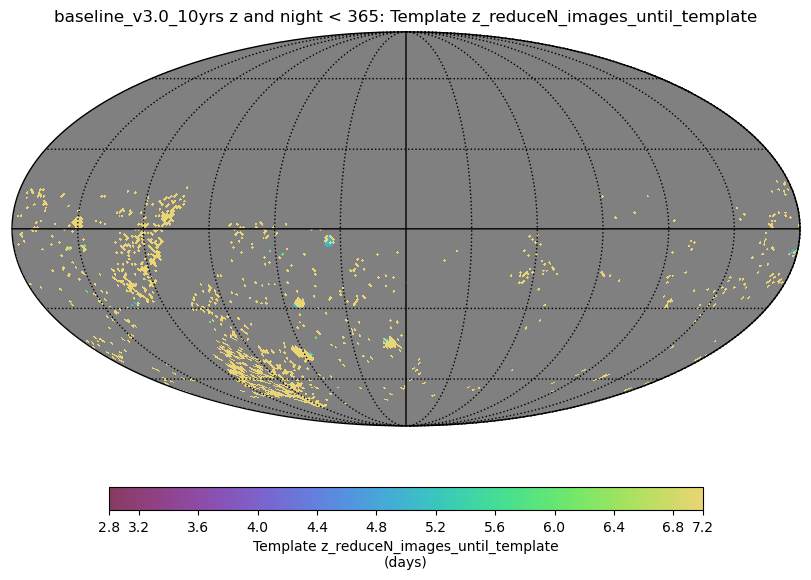

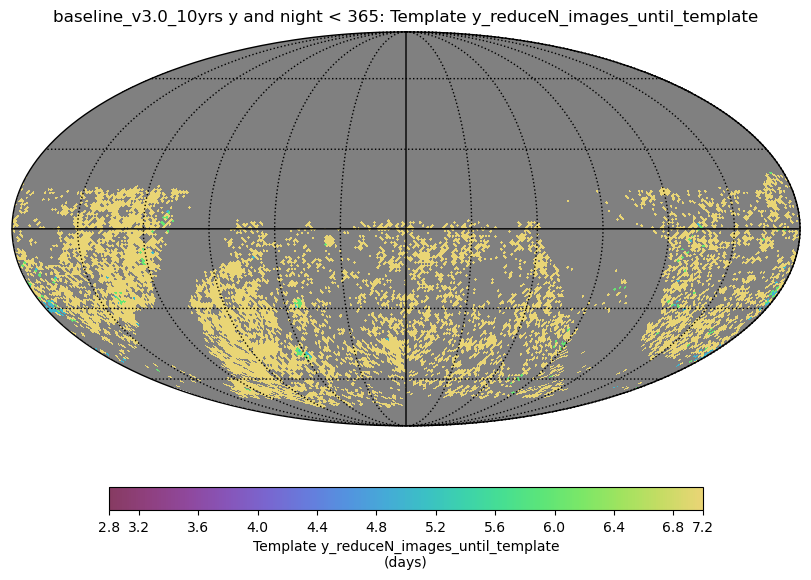

In [10]:
for f in 'ugrizy':
    k = f'Template {f}_reduceN_images_until_template'
    ph.set_metric_bundles([bdict[k]])
    plotDict = {'figsize': (8, 6), 'color_min': 3, 'color_max': 7}
    ph.plot(plot_func=maf.HealpixSkyMap(), plot_dicts=plotDict)

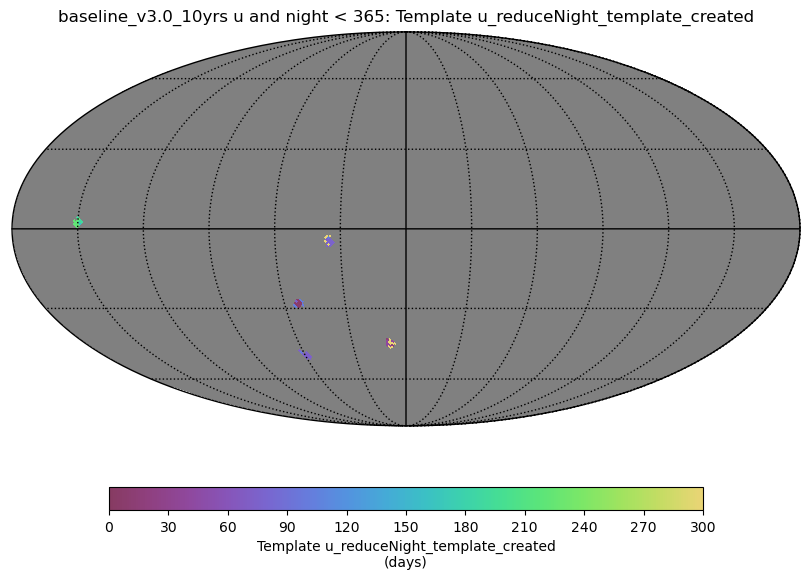

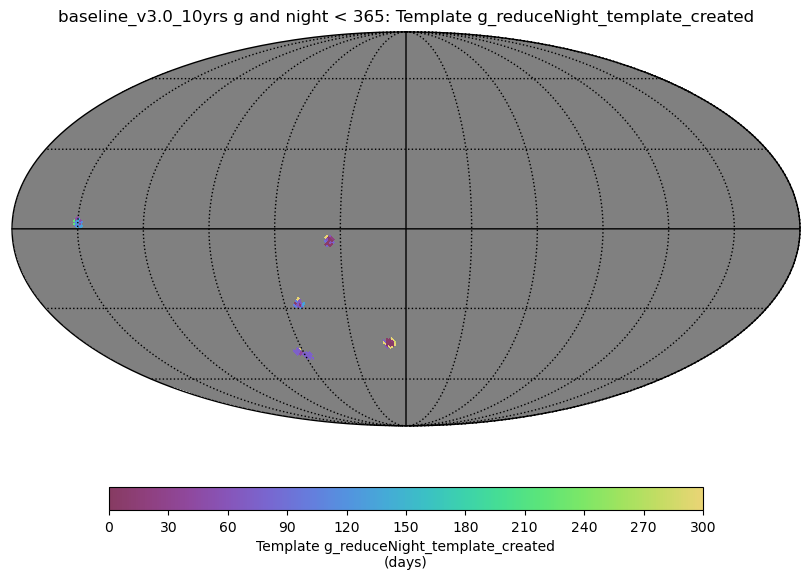

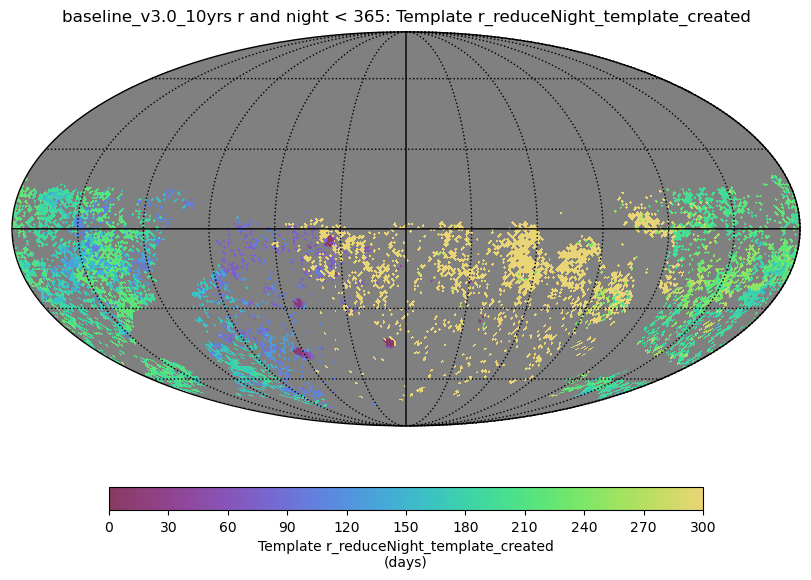

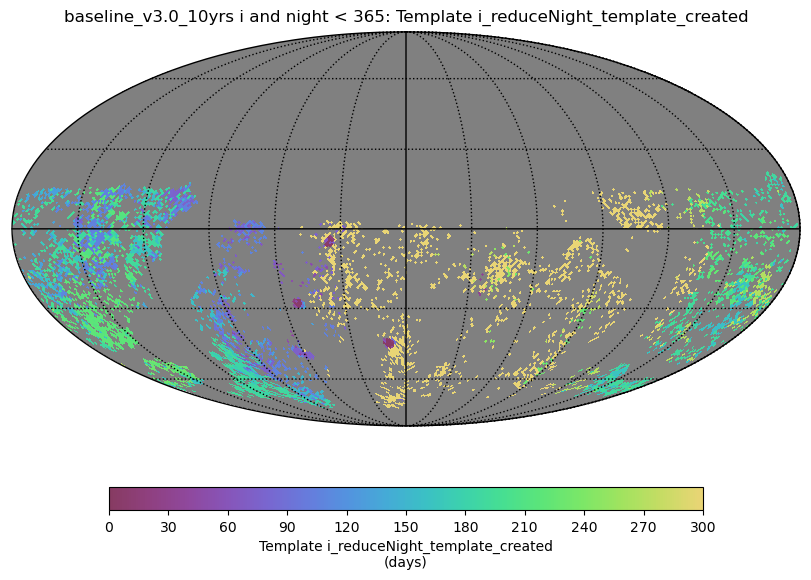

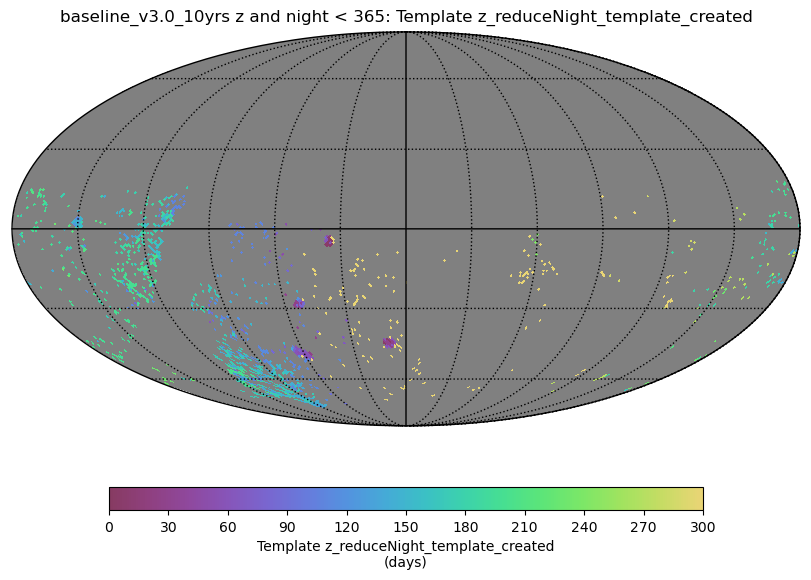

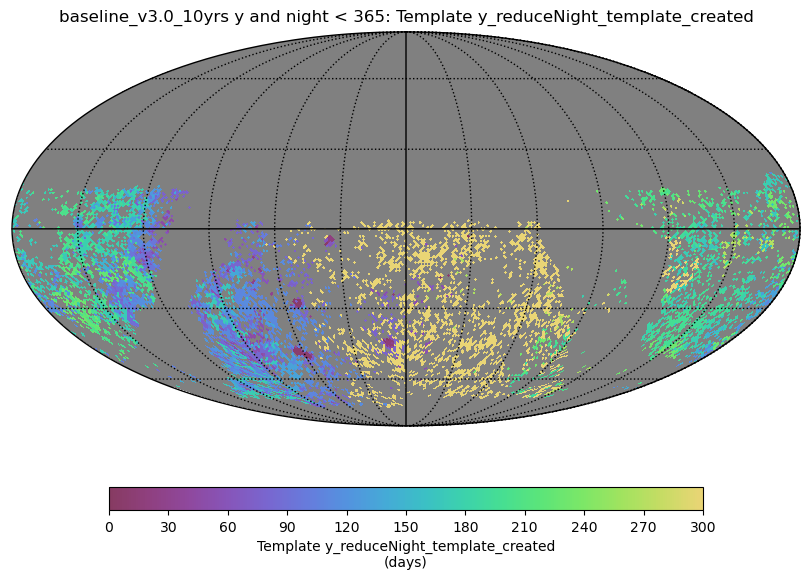

In [11]:
for f in 'ugrizy':
    k = f'Template {f}_reduceNight_template_created'
    ph.set_metric_bundles([bdict[k]])
    plotDict = {'figsize': (8, 6), 'color_min': 0, 'color_max': 300}
    ph.plot(plot_func=maf.HealpixSkyMap(), plot_dicts=plotDict)   

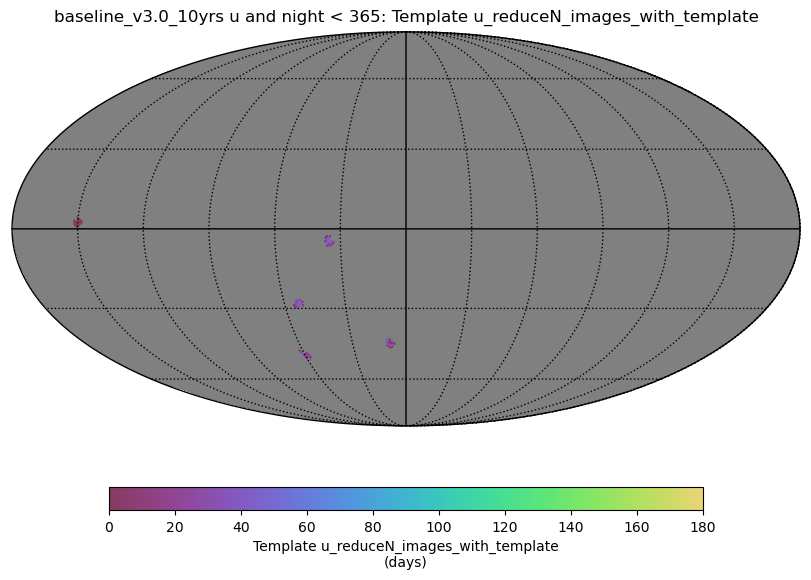

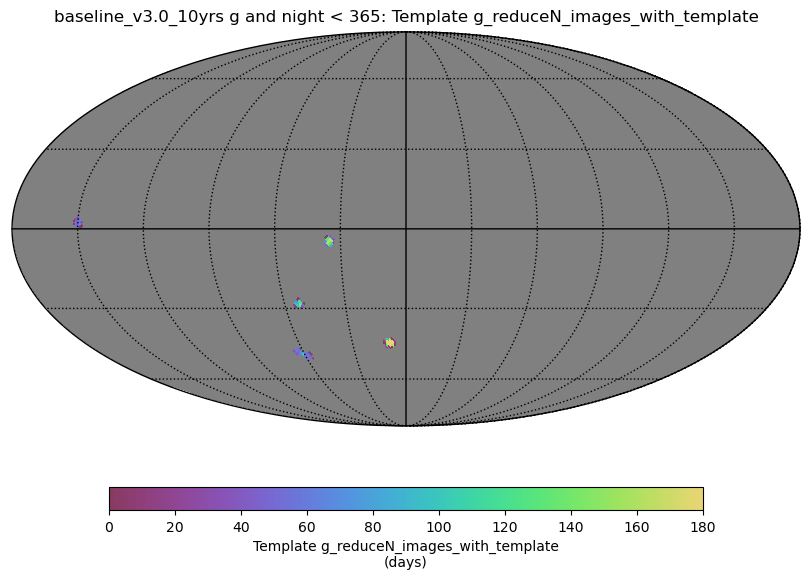

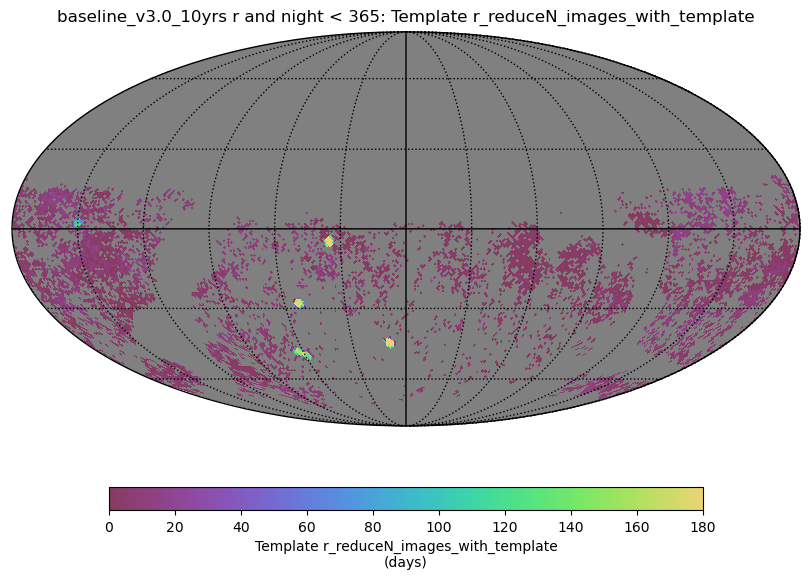

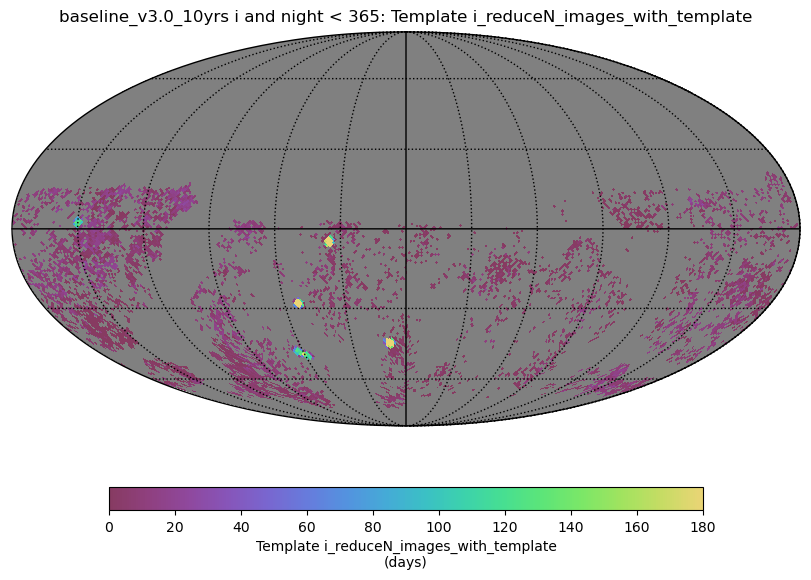

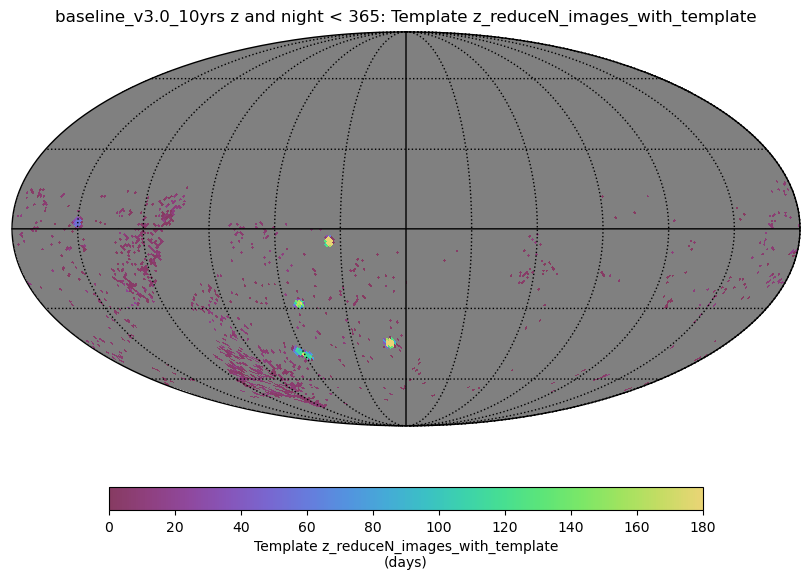

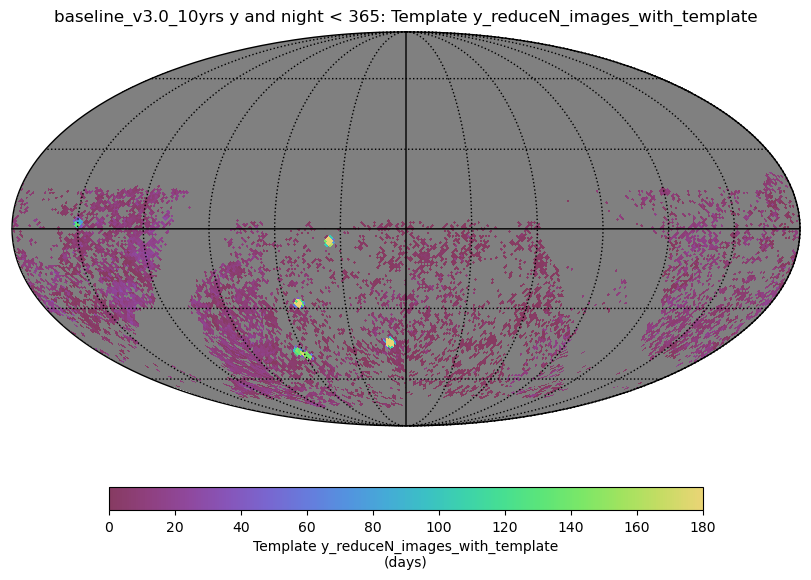

In [12]:
for f in 'ugrizy':
    k = f'Template {f}_reduceN_images_with_template'
    ph.set_metric_bundles([bdict[k]])
    plotDict = {'figsize': (8, 6), 'color_min': 0, 'color_max': 180}
    ph.plot(plot_func=maf.HealpixSkyMap(), plot_dicts=plotDict)
    
#returns days instead of images (need to fix)

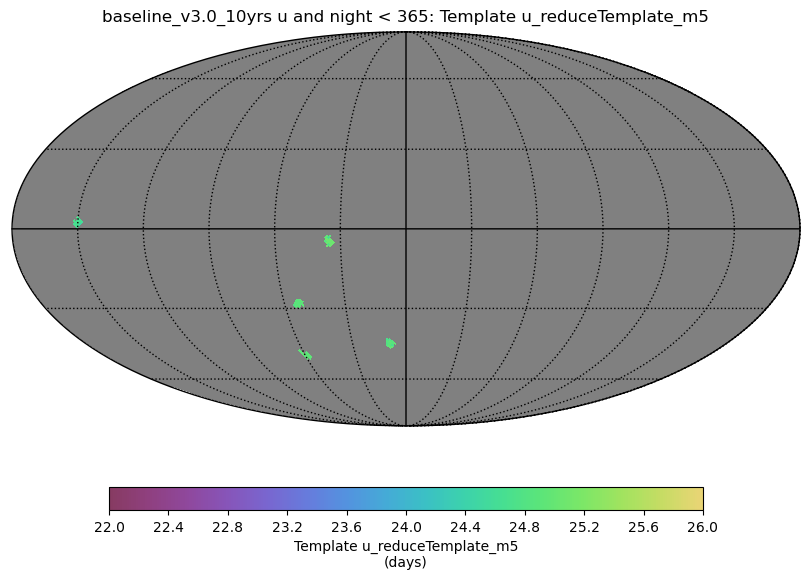

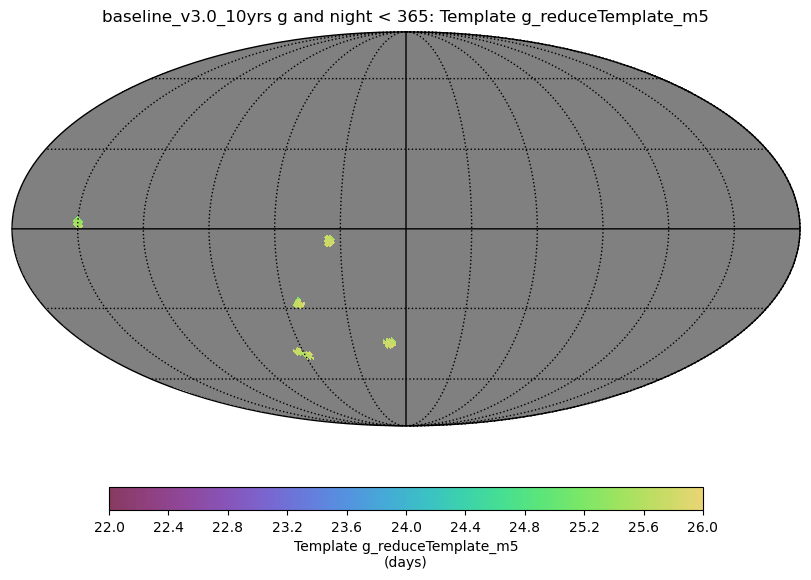

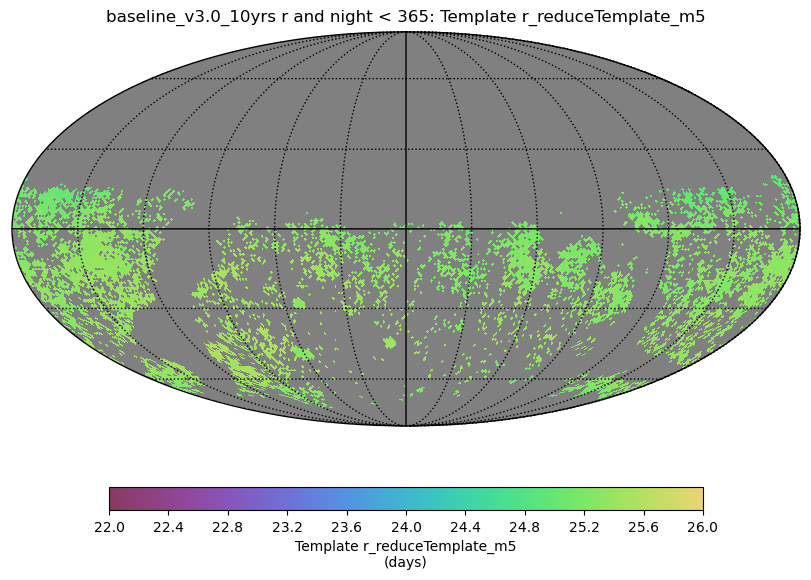

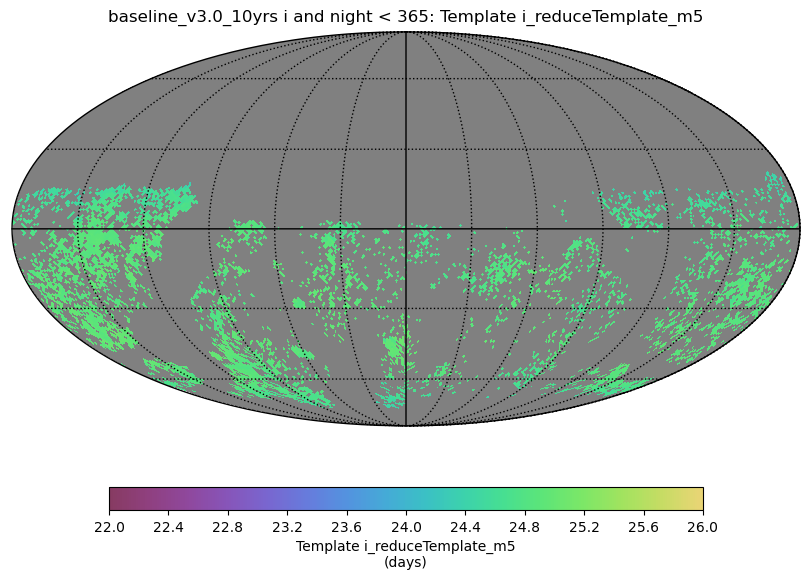

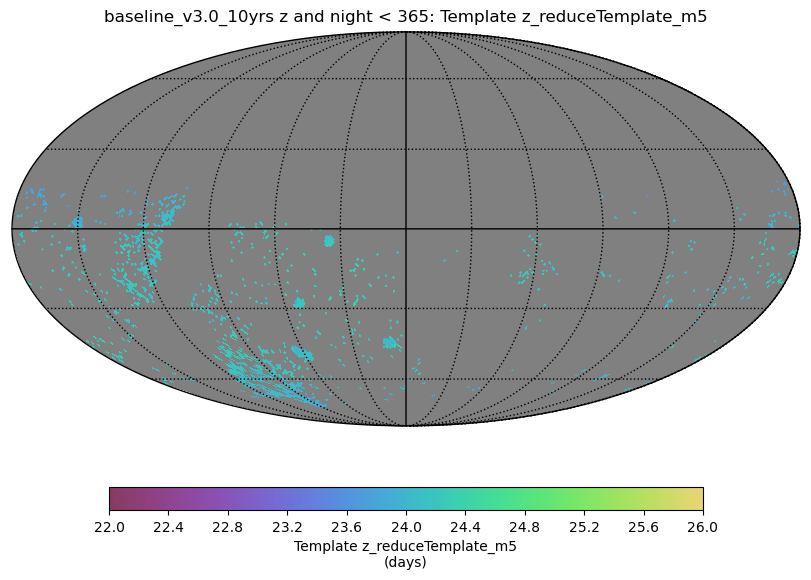

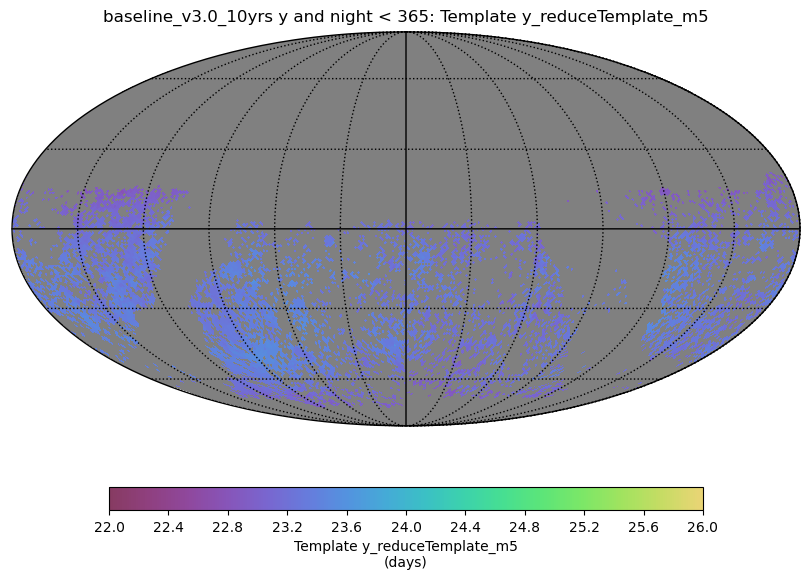

In [13]:
for f in 'ugrizy':
    k = f'Template {f}_reduceTemplate_m5'
    ph.set_metric_bundles([bdict[k]])
    plotDict = {'figsize': (8, 6), 'color_min': 22, 'color_max': 26}
    ph.plot(plot_func=maf.HealpixSkyMap(), plot_dicts=plotDict)

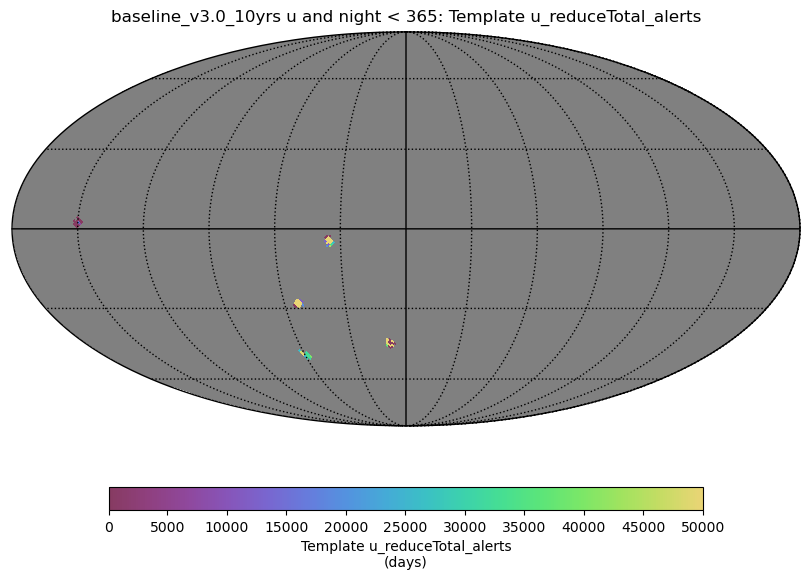

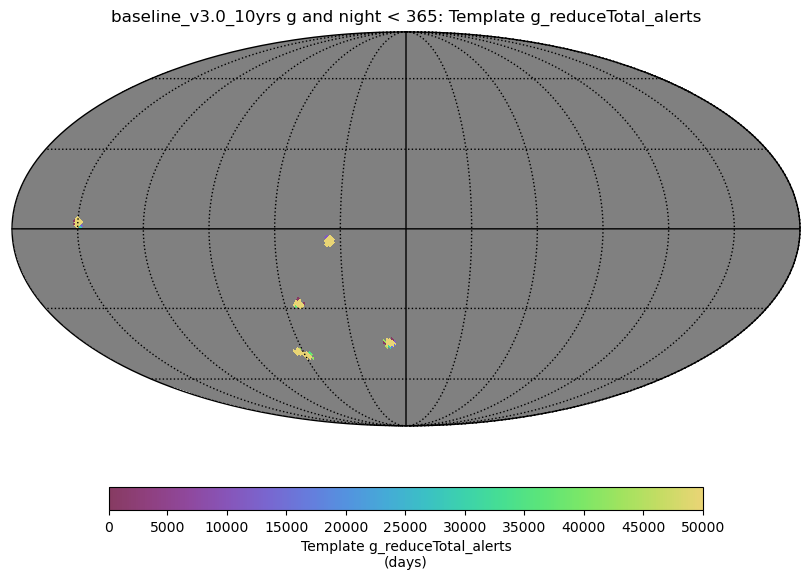

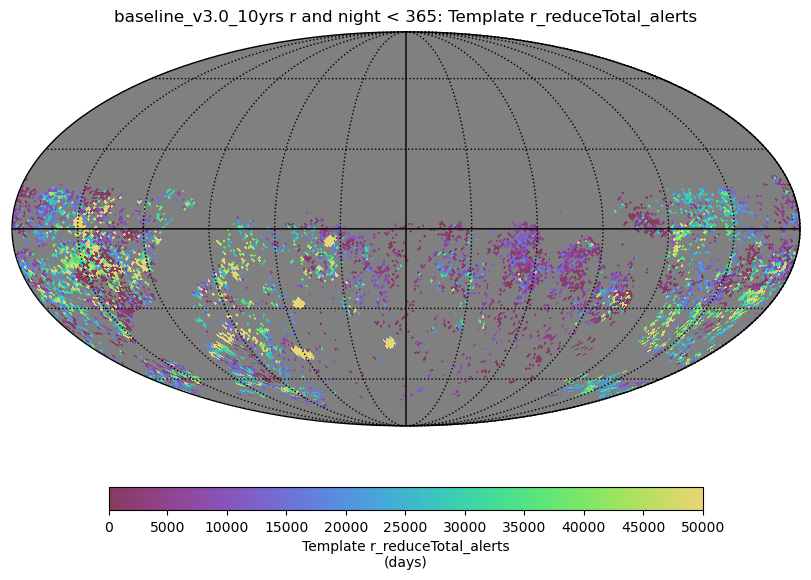

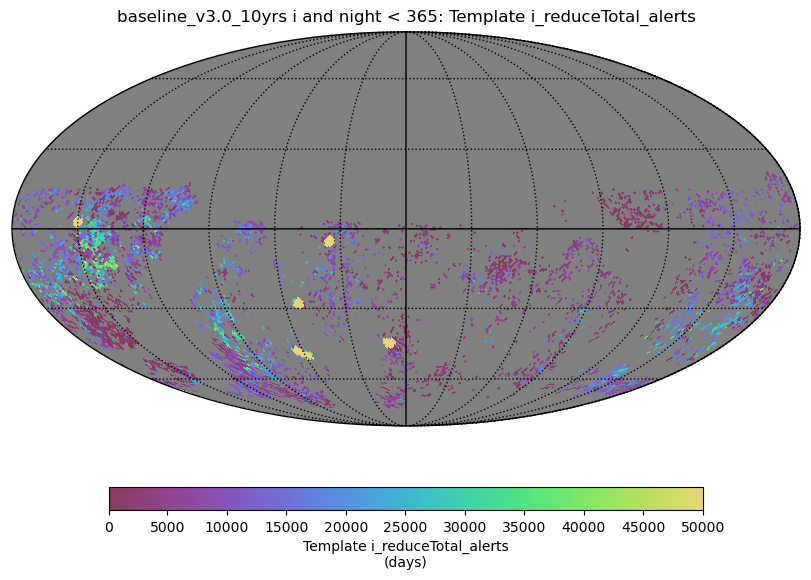

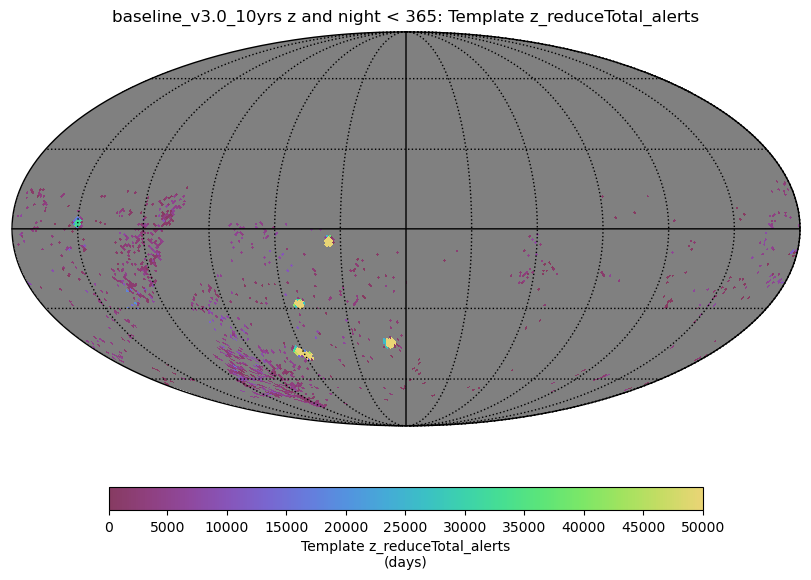

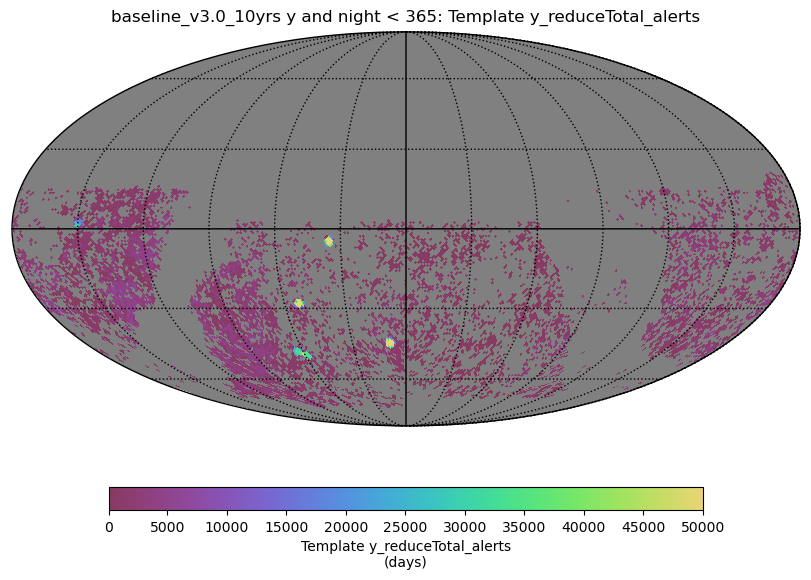

In [14]:
for f in 'ugrizy':
    k = f'Template {f}_reduceTotal_alerts'
    ph.set_metric_bundles([bdict[k]])
    plotDict = {'figsize': (8, 6), 'color_min': 100, 'color_max': 50000}
    ph.plot(plot_func=maf.HealpixSkyMap(), plot_dicts=plotDict)

In [15]:
nights = np.arange(0, 3650, 1)
pixarea = hp.nside2pixarea(nside, degrees=True)
area_over_time = {}
area_since_first = {}
for f in 'ugrizy':
    k = f'Template {f}_reduceNight_template_created'
    counts, bins = np.histogram(bdict[k].metric_values.compressed(), bins=nights)
    area_over_time[f] = counts.cumsum() * pixarea 
    k = f'Template {f}_reduceN_nights_without_template'
    counts, bins = np.histogram(bdict[k].metric_values.compressed(), bins=nights)
    area_since_first[f] = counts.cumsum() * pixarea 

In [16]:
# Count up area in footprint, for reference (varies by filter)
footprint_area = {}
for f in 'ugrizy':
    k = f'Template {f}_reduceNight_template_created'
    footprint_area[f] = len(bdict[k].metric_values.compressed()) * pixarea

{'u': 57.91126151957051, 'g': 80.57218994027201, 'r': 5893.519976672813, 'i': 4616.954342306629, 'z': 1035.6883581905797, 'y': 6574.187122939069}


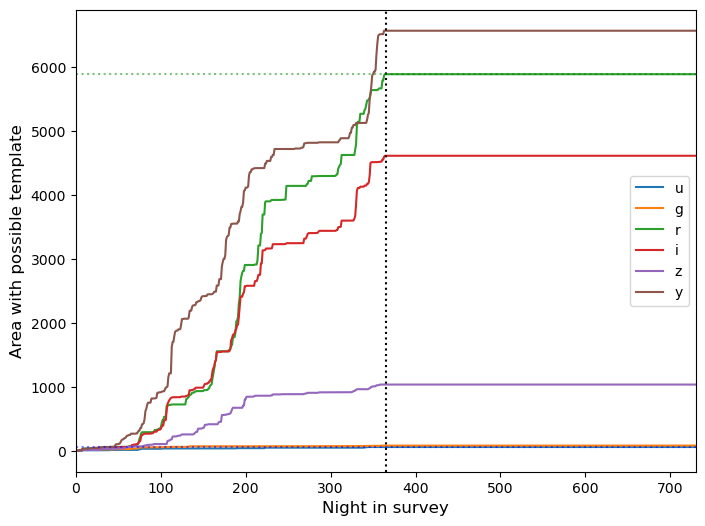

In [17]:
plt.figure(figsize=(8, 6))
for f in 'ugrizy':
    plt.plot(nights[:-1], area_over_time[f], label=f)
plt.legend()
plt.xlim(0, 365*2)
plt.xlabel('Night in survey', fontsize='large')
plt.ylabel('Area with possible template', fontsize='large')
plt.axvline(365, color='k', linestyle=':')
plt.axhline(footprint_area['u'], color='b', linestyle=':', alpha=0.5)
plt.axhline(footprint_area['r'], color='g', linestyle=':', alpha=0.5)
print(footprint_area)

{'u': 57.91126151957051, 'g': 80.57218994027201, 'r': 5893.519976672813, 'i': 4616.954342306629, 'z': 1035.6883581905797, 'y': 6574.187122939069}


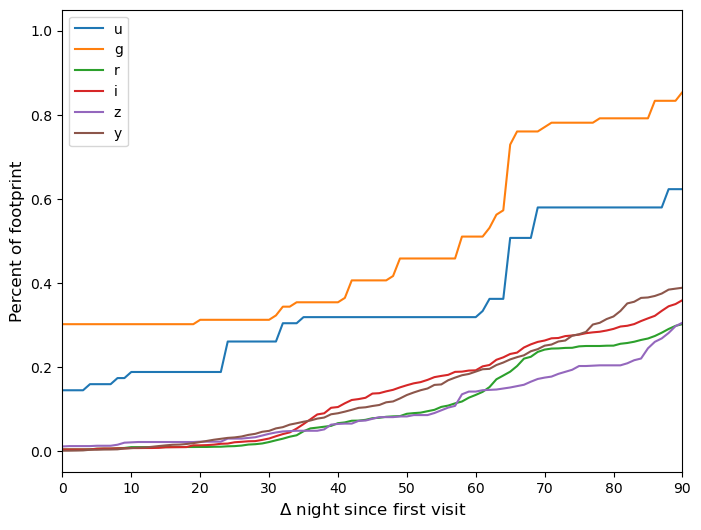

In [18]:
plt.figure(figsize=(8, 6))
for f in 'ugrizy':
    # Show percent of footprint 
    plt.plot(nights[:-1], area_since_first[f] / footprint_area[f], label=f)
plt.legend()
plt.xlim(0, 365*2)
plt.xlim(0, 90)
plt.xlabel(r'$\Delta$ night since first visit', fontsize='large')
#plt.ylabel('Area with possible template', fontsize='large')
plt.ylabel('Percent of footprint', fontsize='large')
plt.axvline(365, color='k', linestyle=':')
print(footprint_area)

In [19]:
visit_maps= {}
for f in 'ugrizy':
    visit_maps[f + ' 1yr'] = maf.MetricBundle(maf.CountMetric(col='observationStartMJD', metric_name='Nvisits'),
                                    maf.HealpixSlicer(nside=128),
                                    f"night < 365.25 and filter = '{f}'", run_name=run_name)
    visit_maps[f + ' 2yr'] = maf.MetricBundle(maf.CountMetric(col='observationStartMJD', metric_name='Nvisits'),
                                    maf.HealpixSlicer(nside=128),
                                    f"night < 365.25*2 and filter = '{f}'", run_name=run_name)
g2 = maf.MetricBundleGroup(visit_maps, opsdb, 'temp')
g2.run_all()

Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/opt/anaconda3/envs/rubin/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/7b/jsrl76yd6v1b3v92fpy66jb00000gn/T/ipykernel_4709/757701415.py", line 10, in <module>
    g2.run_all()
  File "/Users/giovannigollotti/rubin_sim/rubin_sim/maf/metric_bundles/metric_bundle_group.py", line 222, in run_all
    self.run_current(
  File "/Users/giovannigollotti/rubin_sim/rubin_sim/maf/metric_bundles/metric_bundle_group.py", line 321, in run_current
    self._run_compatible(compatible_list)
  File "/Users/giovannigollotti/rubin_sim/rubin_sim/maf/metric_bundles/metric_bundle_group.py", line -1, in _run_compatible
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/anaconda3/envs/rubin/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2102, in show

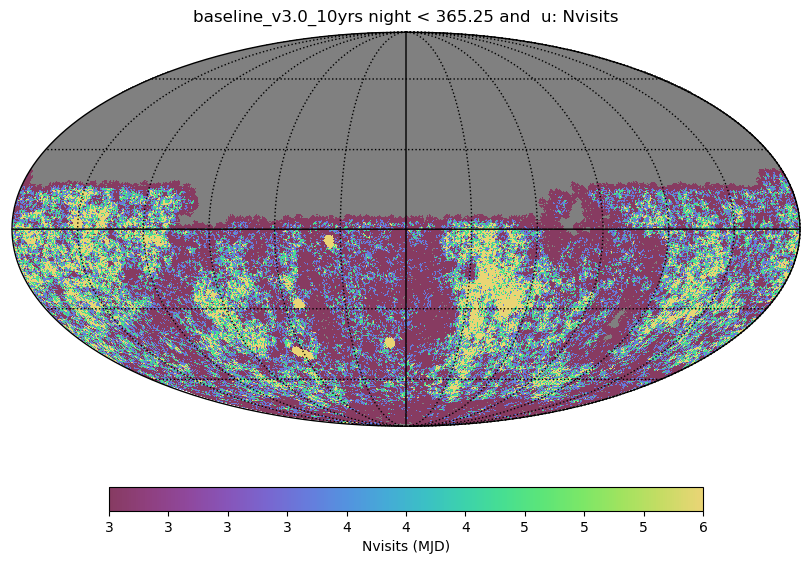

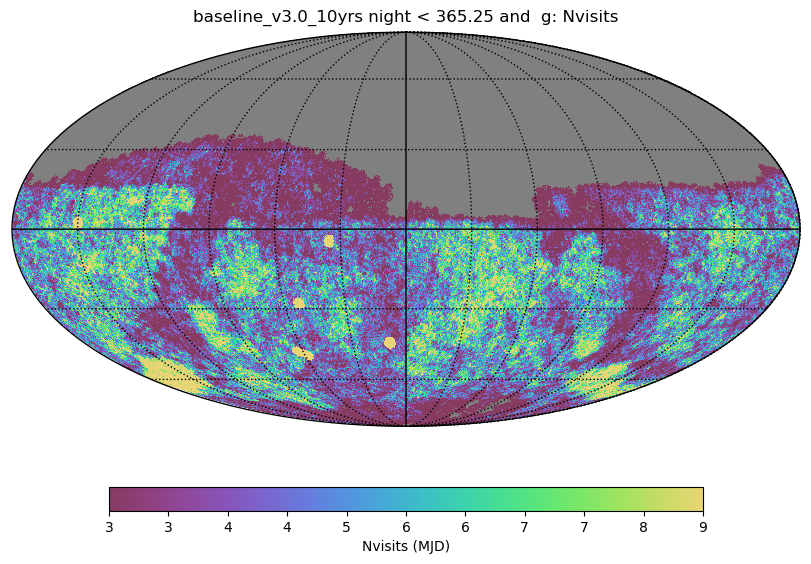

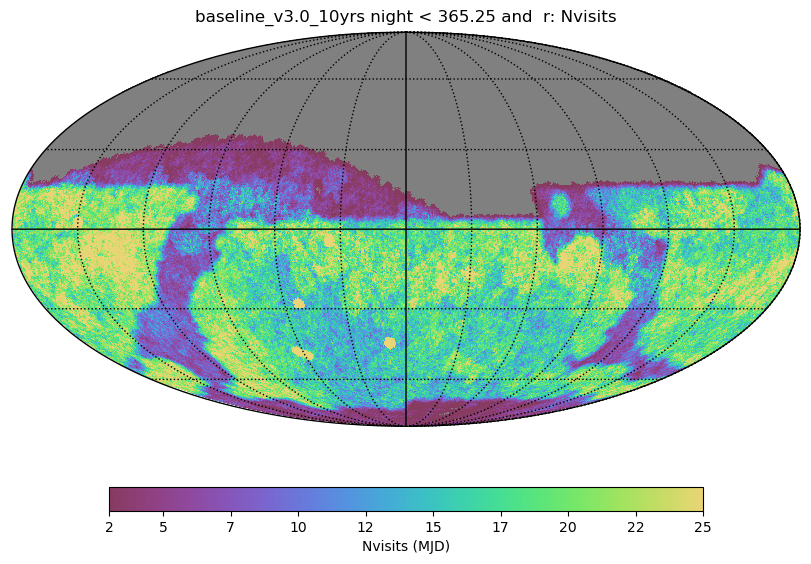

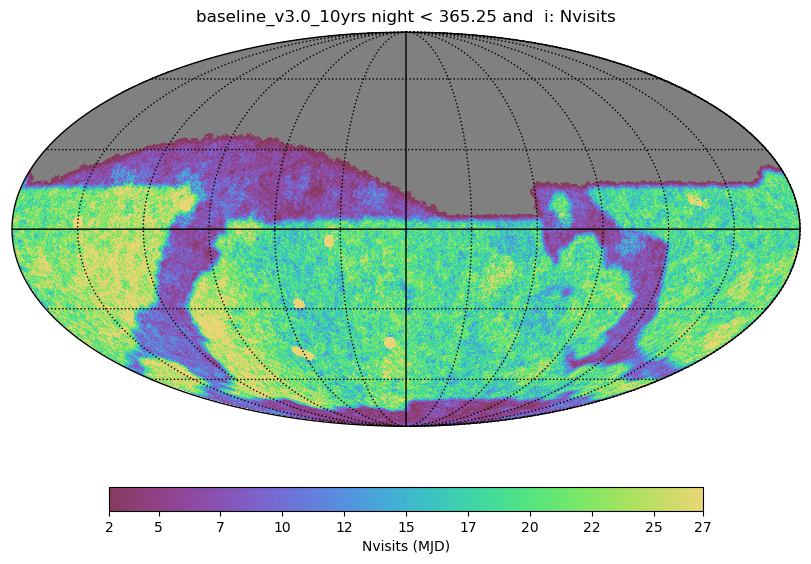

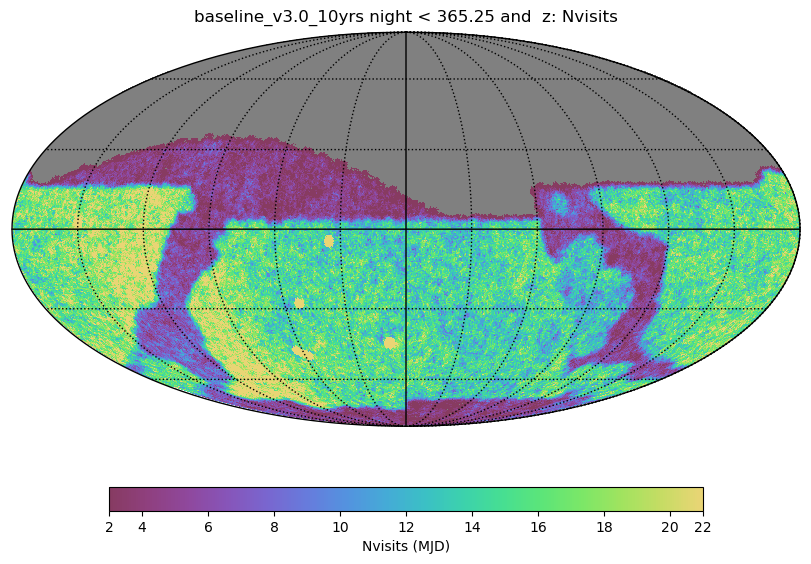

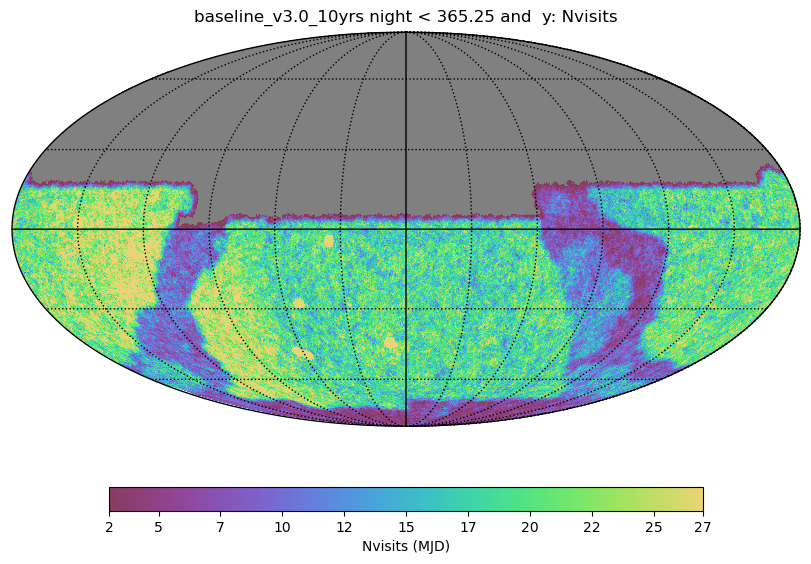

In [22]:
for f in 'ugrizy':
    k = f'{f} 1yr'
    ph.set_metric_bundles([visit_maps[k]])
    colormax = np.percentile(visit_maps[k].metric_values.compressed(), 95)
    plotDict = {'figsize': (8, 6), 'color_min': 3, 'color_max': colormax}
    ph.plot(plot_func=maf.HealpixSkyMap(), plot_dicts=plotDict)

[23.72100475 24.10382764 23.85502564 24.21961363 24.41977699 24.07478099
 23.85612679 23.92341978 24.18862804 24.30782146 24.36524865 24.07512721
 24.27419103 24.19776076 23.77750404 23.95284682 24.3538404  24.37483531
 24.00757209 24.05822923 24.29598737 22.97349087 22.85376395 22.74232737
 22.61784217 22.44426428 22.33138525]
[60293.29522726 60293.29567417 60310.29553477 60318.21125218
 60322.25368757 60328.18771859 60347.26910313 60350.26092215
 60354.12272822 60355.23241968 60379.13960043 60382.20381086
 60406.03000856 60410.04657488 60430.00507354 60432.03897604
 60432.9815127  60432.98376498 60436.06083872 60436.06128601
 60438.01293207 60582.38983399 60582.39007531 60582.39294801
 60582.39318932 60582.39606278 60582.39630407]


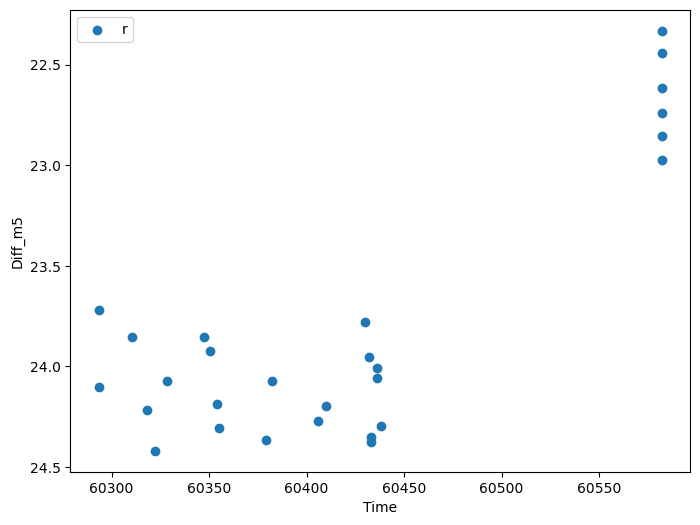

In [23]:
index = 0 #Index = 11333 for longest time series
longest_series = 0.0

for k in range(0, len(lcs) - 1): #All of the points on the graph are from the same index
    for j in range(0, len(lcs[k]['mjd']) - 1):
        if lcs[k]['mjd'][j] > longest_series:
            longest_series = lcs[k]['mjd'][j]
            index = k
        else:
            pass

my_y = lcs[index]['diff_m5'] 
print(my_y)

my_x = lcs[index]['mjd'] 
print(my_x)

my_band = lcs[index]['band'][0] #By construction, all the filters are the same

plt.figure(figsize=(8, 6))
plt.scatter(my_x, my_y, label = my_band)

plt.legend()  
plt.ylabel(f"Diff_m5")
plt.xlabel(f"Time")  
plt.gca().invert_yaxis()
    
#Look for longest time series (make a for loop for the arrays and use if/else statements to find longest time series)

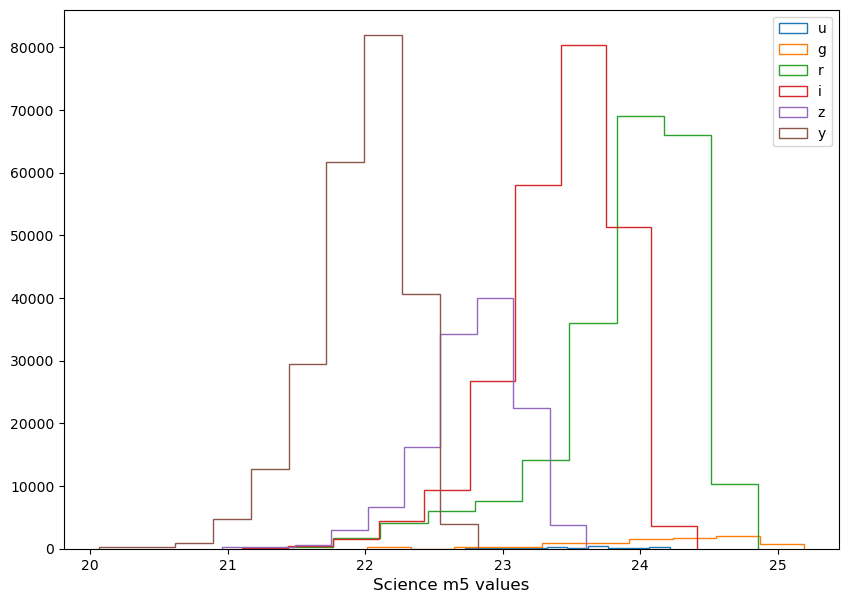

<Figure size 640x480 with 0 Axes>

In [20]:
#Create histogram for science m5, template m5, diff m5, # of alerts

#Science m5
fig, ax = plt.subplots(figsize = (10,7))

for f in 'ugrizy':
    lcs = lcs_all_filters[f]
    science_m5_data = np.array([])
    for lc in lcs:
        science_m5_data = np.append(science_m5_data, lc['science_m5'])
    plt.hist(science_m5_data, label = f, histtype = "step")

plt.xlabel('Science m5 values', fontsize='large')
plt.legend()
plt.show()

plt.savefig(f'{metric_configuration}_science_m5.pdf')

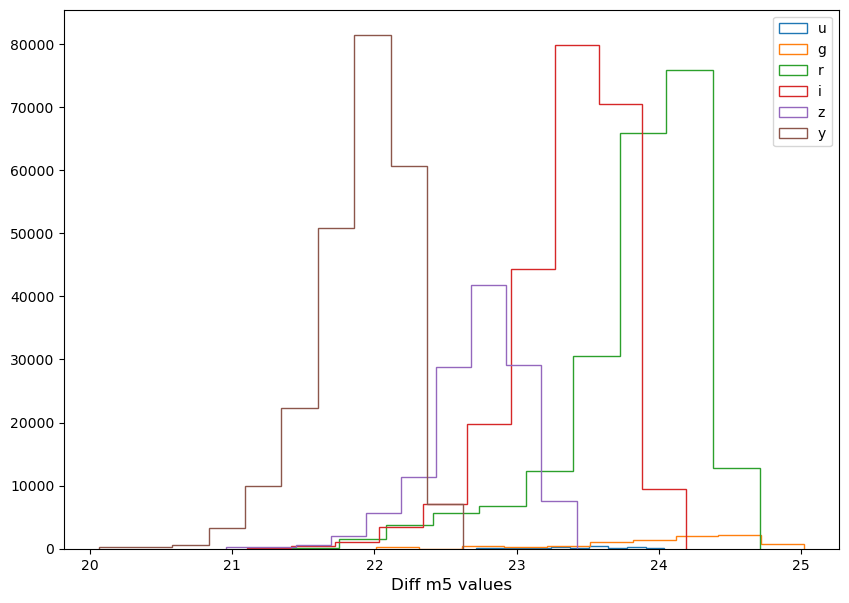

<Figure size 640x480 with 0 Axes>

In [21]:
#Diff m5
fig, ax = plt.subplots(figsize = (10,7))

for f in 'ugrizy':
    lcs = lcs_all_filters[f]
    diff_m5_data = np.array([])
    for lc in lcs:
        diff_m5_data = np.append(diff_m5_data, lc['diff_m5'])
    plt.hist(diff_m5_data, label = f, histtype = "step")

plt.xlabel('Diff m5 values', fontsize='large')
plt.legend()
plt.show()

plt.savefig(f'{metric_configuration}_diff_m5.pdf')

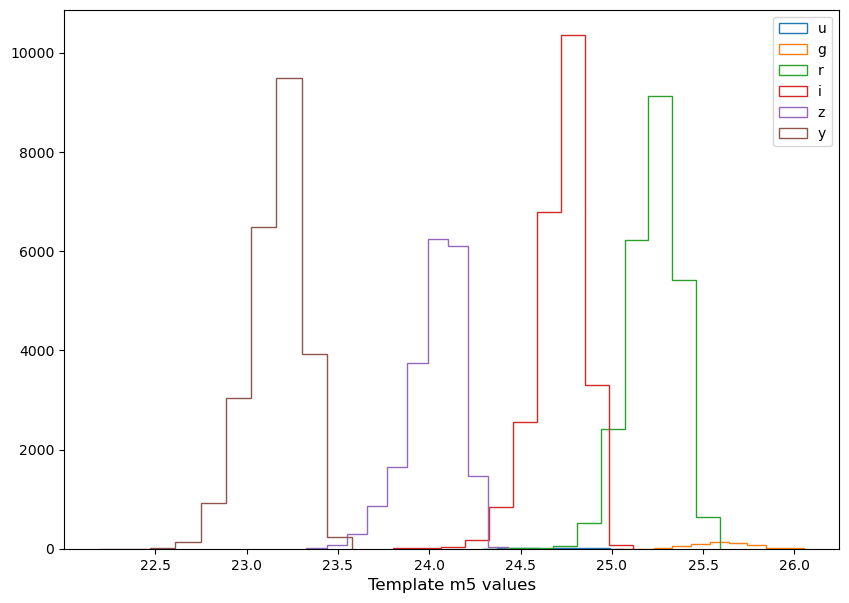

<Figure size 640x480 with 0 Axes>

In [22]:
#Template m5 (all the other histograms only focus on the 'r' band)
fig, ax = plt.subplots(figsize = (10,7))

for f in 'ugrizy':
    temp_m5_data = [v['Template_m5'] for v in bdict[f].metric_values.tolist() if v is not None]
    plt.hist(temp_m5_data, label = f, histtype = "step")

plt.xlabel('Template m5 values', fontsize='large')
plt.legend()
plt.show()

plt.savefig(f'{metric_configuration}_template_m5.pdf')

In [7]:
# Number of alerts

n_alerts_all_filters = {}
for f in 'ugrizy':
    lcs = lcs_all_filters[f]
    alerts_data = np.zeros(365) #Alerts stored in this array
    for lc in lcs:
        for k in range(0, len(lc['night']) - 1):
            alerts_data[lc['night'][k]] += lc['n_alerts'][k]
    n_alerts_all_filters[f] = alerts_data

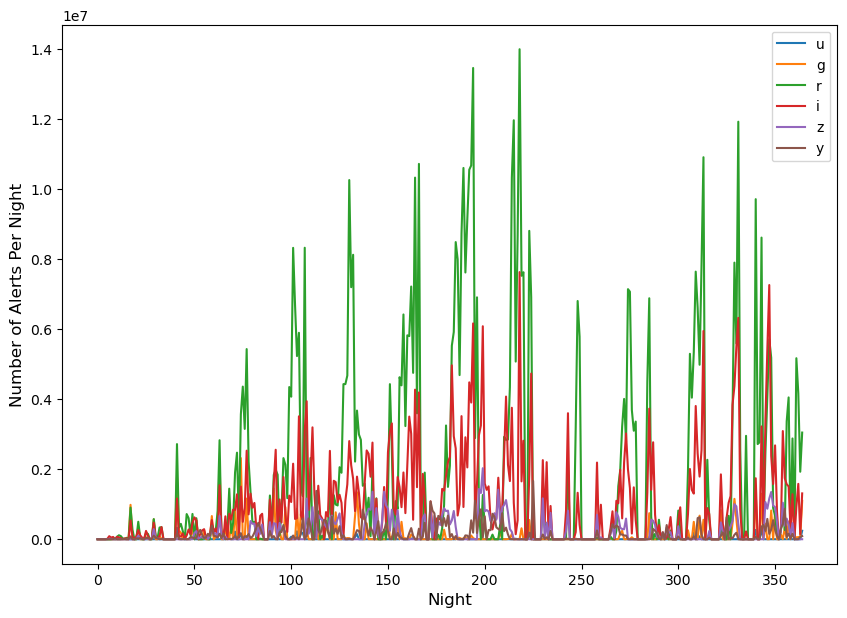

In [24]:
plt.figure(figsize = (10,7))
for f in 'ugrizy':
    plt.plot(np.arange(0, 365, 1), n_alerts_all_filters[f], label = f)
plt.legend()
plt.xlabel('Night', fontsize = 'large')
plt.ylabel('Number of Alerts Per Night', fontsize = 'large')

plt.savefig(f'{metric_configuration}_num_alerts.pdf')

In [9]:
bdict = {}
for f in 'ugrizy':
    m = TemplateTime(metric_name=f'Template {f}', n_images_in_template = 3, seeing_percentile = 50, m5_percentile = 50)
    constraint = f'filter == "{f}" and night < 365'
    bdict[f] = maf.MetricBundle(m, s, constraint, run_name=run_name)

metric_configuration = 'three_images_50_percent_in_template'
g = maf.MetricBundleGroup(bdict, opsdb, metric_configuration)
g.run_all()

In [10]:
def get_lc(v):
    """Extract lightcurves saved with `outputLc=True` from the metric datastructure
    
    Parameters
    ----------
    v : `metricValue`
        Input metricValue containing the lightcurve
    
    Returns
    -------
    lc : dict
        dict with columns `t`, `mag`, `mag_unc`, `maglim`, `filter`
    """
    if v is not None:
        return v['Diffim_lc']
    else:
        pass
        #return None

In [11]:
lcs_all_filters_run_two = {}
for f in 'ugrizy':
    lcs = [get_lc(v) for v in bdict[f].metric_values.tolist() if get_lc(v) is not None]
    lcs = [lc for lc in lcs if len(lc['diff_m5']) > 0] # time series of limiting magnitude
    lcs_all_filters_run_two[f] = lcs

In [14]:
n_alerts_all_filters_run_two = {}
for f in 'ugrizy':
    lcs = lcs_all_filters_run_two[f]
    alerts_data_two = np.zeros(365) #Alerts stored in this array
    for lc in lcs:
        for k in range(0, len(lc['night']) - 1):
            alerts_data_two[lc['night'][k]] += lc['n_alerts'][k]
    n_alerts_all_filters_run_two[f] = alerts_data_two

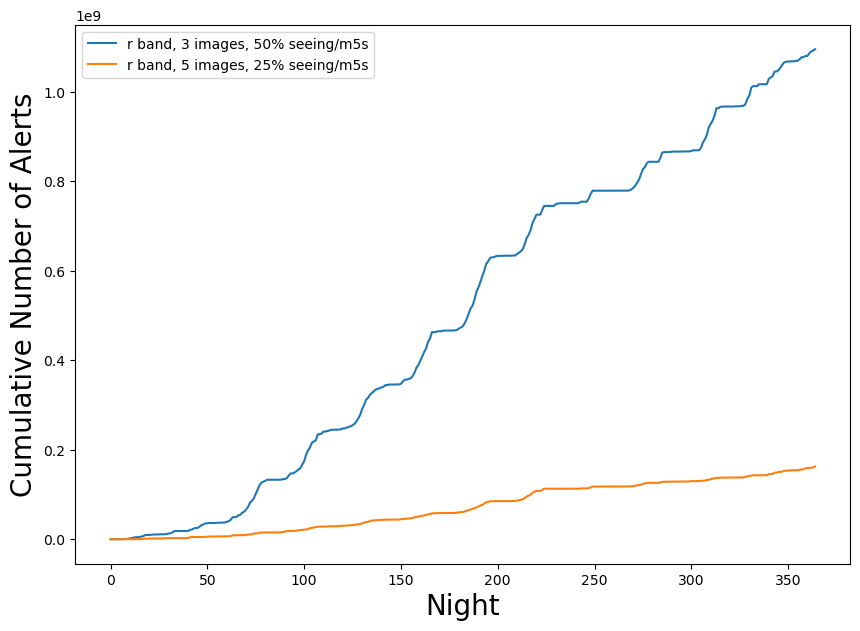

In [19]:
plt.figure(figsize = (10,7))
for f in 'r':
    plt.plot(np.arange(0, 365, 1), np.cumsum(n_alerts_all_filters_run_two[f]), label = "r band, 3 images, 50% seeing/m5s")
    plt.plot(np.arange(0, 365, 1), np.cumsum(n_alerts_all_filters[f]), label = "r band, 5 images, 25% seeing/m5s")
    
plt.legend()
plt.xlabel('Night', fontsize = 20)
plt.ylabel('Cumulative Number of Alerts', fontsize = 20)

plt.savefig('r_comparative_cumulative_num_alerts.pdf')

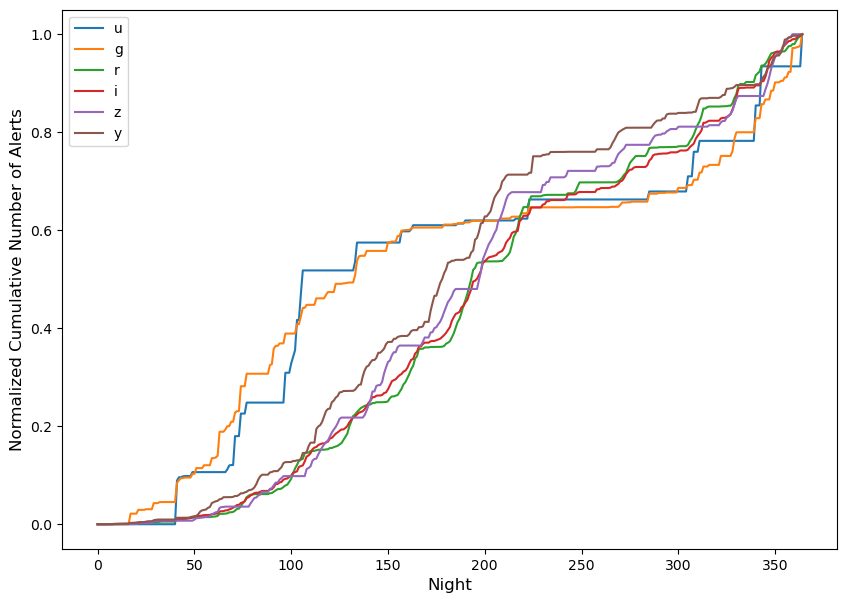

In [26]:
plt.figure(figsize = (10,7))
for f in 'ugrizy':
    plt.plot(np.arange(0, 365, 1), np.cumsum(n_alerts_all_filters[f])/np.sum(n_alerts_all_filters[f]), label = f)

plt.legend()
plt.xlabel('Night', fontsize = 'large')
plt.ylabel('Normalized Cumulative Number of Alerts', fontsize = 'large')

plt.savefig(f'{metric_configuration}_normalized_cumulative_alerts.pdf')